<a href="https://colab.research.google.com/github/SirvavialTAG/NLP/blob/main/NLP_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pandas nltk pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 79.2 MB/s eta 0:00:00


In [32]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import pymorphy3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### **Для работы был выбран довольной объёмный датасет отзывов пользователей на определённый товары, разбитые на 17 категорий**

In [33]:
# Загрузка набора данных
df = pd.read_csv('reviews.csv')
df.rename(columns={df.columns[0]: 'number'}, inplace=True)
df.head(10)

,number,text,plus,minus,language,rating,category
0,0,"Парфюм оригинальный. Всё, как в профессиональн...",NaN,NaN,russian,5.0,perfumes
1,1,Мой любимый DKNY. Запах просто шикарный. Спаси...,NaN,NaN,russian,5.0,perfumes
2,2,NaN,Шикарный запах! Безумно нравится! Не пожалеете...,NaN,russian,5.0,perfumes
3,3,NaN,Иісі қатты ұнады.,NaN,kazakh,5.0,perfumes
4,4,"Запах просто классный, как раз то, что мне нуж...","Мне все понравилось - и качество товара, и зап...","Единственное, что мне не понравилось, это то, ...",russian,4.0,perfumes
5,5,"Парфюм хороший, оригинал! Магазин Parfum-Shop-...",NaN,NaN,russian,5.0,perfumes
6,6,Доставка работает супер!,"Аромат неповторим, как и ожидала! Спасибо!",NaN,russian,5.0,perfumes
7,7,NaN,NaN,"Запах нестойкий. Доставку, сказали, осуществят...",russian,2.0,perfumes
8,8,NaN,Люблю этот аромат.,NaN,russian,5.0,perfumes
9,9,NaN,Очень вкусная вода. Довольно стойкая.,NaN,russian,5.0,perfumes


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119048 entries, 0 to 119047
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   number    119048 non-null  int64  
 1   text      59479 non-null   object 
 2   plus      83900 non-null   object 
 3   minus     36879 non-null   object 
 4   language  119048 non-null  object 
 5   rating    119048 non-null  float64
 6   category  119048 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 6.4+ MB


In [35]:
# Вывод всех категорий товаров в датасете
df['category'].unique()

array(['perfumes', 'smartphones', 'car-electronics', 'memory-cards',
       'wearables', 'tires', 'power-banks', 'portable-speakers',
       'car-audio', 'books', 'beauty', 'small-home-appl',
       'kitchen-home-appl', 'big-home-appl', 'climate-equipment',
       'watches', 'headphones'], dtype=object)

In [36]:
# Оставляем только отзывы на русском языке
russian_df = df[df['language'] == 'russian'].copy()
russian_df.head(10)

,number,text,plus,minus,language,rating,category
0,0,"Парфюм оригинальный. Всё, как в профессиональн...",NaN,NaN,russian,5.0,perfumes
1,1,Мой любимый DKNY. Запах просто шикарный. Спаси...,NaN,NaN,russian,5.0,perfumes
2,2,NaN,Шикарный запах! Безумно нравится! Не пожалеете...,NaN,russian,5.0,perfumes
4,4,"Запах просто классный, как раз то, что мне нуж...","Мне все понравилось - и качество товара, и зап...","Единственное, что мне не понравилось, это то, ...",russian,4.0,perfumes
5,5,"Парфюм хороший, оригинал! Магазин Parfum-Shop-...",NaN,NaN,russian,5.0,perfumes
6,6,Доставка работает супер!,"Аромат неповторим, как и ожидала! Спасибо!",NaN,russian,5.0,perfumes
7,7,NaN,NaN,"Запах нестойкий. Доставку, сказали, осуществят...",russian,2.0,perfumes
8,8,NaN,Люблю этот аромат.,NaN,russian,5.0,perfumes
9,9,NaN,Очень вкусная вода. Довольно стойкая.,NaN,russian,5.0,perfumes
10,10,Очень долго ждала появления на Kaspi.kz!,Духи просто супер! Стойкий запах! Не пожалеете!,-,russian,5.0,perfumes


In [37]:
# Объединение столбцов
russian_df['review'] = russian_df[['text', 'plus', 'minus']].fillna('').agg(' '.join, axis=1)
russian_df = russian_df.drop(columns=['text', 'plus', 'minus'])
russian_df.head(10)

,number,language,rating,category,review
0,0,russian,5.0,perfumes,"Парфюм оригинальный. Всё, как в профессиональн..."
1,1,russian,5.0,perfumes,Мой любимый DKNY. Запах просто шикарный. Спаси...
2,2,russian,5.0,perfumes,Шикарный запах! Безумно нравится! Не пожалеет...
4,4,russian,4.0,perfumes,"Запах просто классный, как раз то, что мне нуж..."
5,5,russian,5.0,perfumes,"Парфюм хороший, оригинал! Магазин Parfum-Shop-..."
6,6,russian,5.0,perfumes,"Доставка работает супер! Аромат неповторим, к..."
7,7,russian,2.0,perfumes,"Запах нестойкий. Доставку, сказали, осуществ..."
8,8,russian,5.0,perfumes,Люблю этот аромат.
9,9,russian,5.0,perfumes,Очень вкусная вода. Довольно стойкая.
10,10,russian,5.0,perfumes,Очень долго ждала появления на Kaspi.kz! Духи ...


In [38]:
stop_words = set(stopwords.words('russian'))
morph = pymorphy3.MorphAnalyzer()

# Лемматизация и токенизация
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^а-яёa-z0-9 ]', ' ', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [morph.parse(token)[0].normal_form for token in tokens]
    return ' '.join(tokens)

russian_df['review'] = russian_df['review'].apply(preprocess_text)
russian_df.head(10)

,number,language,rating,category,review
0,0,russian,5.0,perfumes,парфюм оригинальный всё профессиональный магаз...
1,1,russian,5.0,perfumes,любимый dkny запах просто шикарный спасибо kas...
2,2,russian,5.0,perfumes,шикарный запах безумно нравиться пожалеть буди...
4,4,russian,4.0,perfumes,запах просто классный нужно летний время прини...
5,5,russian,5.0,perfumes,парфюм хороший оригинал магазин parfum shop kz...
6,6,russian,5.0,perfumes,доставка работать супер аромат неповторимый ож...
7,7,russian,2.0,perfumes,запах нестойкий доставка сказать осуществить 1...
8,8,russian,5.0,perfumes,любить аромат
9,9,russian,5.0,perfumes,очень вкусный вода довольно стойкий
10,10,russian,5.0,perfumes,очень долго ждать появление kaspi kz дух прост...


In [39]:
russian_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112049 entries, 0 to 119047
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   number    112049 non-null  int64  
 1   language  112049 non-null  object 
 2   rating    112049 non-null  float64
 3   category  112049 non-null  object 
 4   review    112049 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.1+ MB


category
smartphones          42674
small-home-appl      11284
big-home-appl        11207
kitchen-home-appl    10822
headphones            6120
beauty                5906
tires                 5201
climate-equipment     4699
car-electronics       3111
perfumes              2705
watches               2220
car-audio             1983
wearables             1886
power-banks            721
portable-speakers      582
memory-cards           504
books                  424
Name: count, dtype: int64


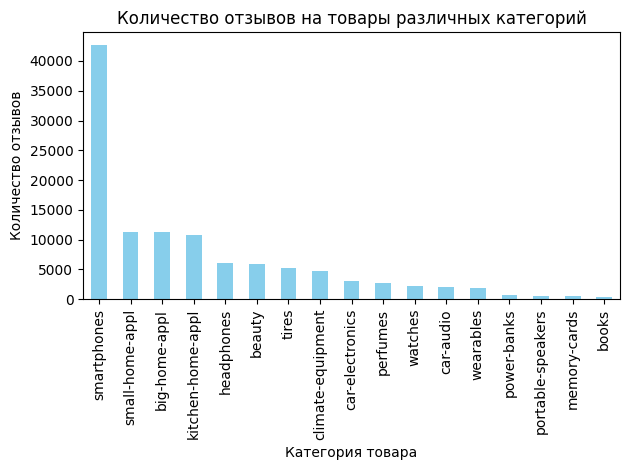

In [41]:
# Считаем количество товаров в каждой категории
category_counts = russian_df['category'].value_counts()
print(category_counts)

# Строим график
category_counts.plot(kind='bar', color='skyblue')
plt.title('Количество отзывов на товары различных категорий')
plt.xlabel('Категория товара')
plt.ylabel('Количество отзывов')
plt.xticks(fontsize='medium')  # чтобы названия категорий были горизонтальными
plt.tight_layout()
plt.show()

In [42]:
# Векторизация
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(russian_df['review'])

In [43]:
# Кластеризация
clusters_number = df['category'].nunique()
kmeans = KMeans(n_clusters=clusters_number, random_state=42)
russian_df['cluster'] = kmeans.fit_predict(X)

russian_df.head(10)

,number,language,rating,category,review,cluster
0,0,russian,5.0,perfumes,парфюм оригинальный всё профессиональный магаз...,8
1,1,russian,5.0,perfumes,любимый dkny запах просто шикарный спасибо kas...,8
2,2,russian,5.0,perfumes,шикарный запах безумно нравиться пожалеть буди...,8
4,4,russian,4.0,perfumes,запах просто классный нужно летний время прини...,8
5,5,russian,5.0,perfumes,парфюм хороший оригинал магазин parfum shop kz...,3
6,6,russian,5.0,perfumes,доставка работать супер аромат неповторимый ож...,3
7,7,russian,2.0,perfumes,запах нестойкий доставка сказать осуществить 1...,8
8,8,russian,5.0,perfumes,любить аромат,8
9,9,russian,5.0,perfumes,очень вкусный вода довольно стойкий,8
10,10,russian,5.0,perfumes,очень долго ждать появление kaspi kz дух прост...,8


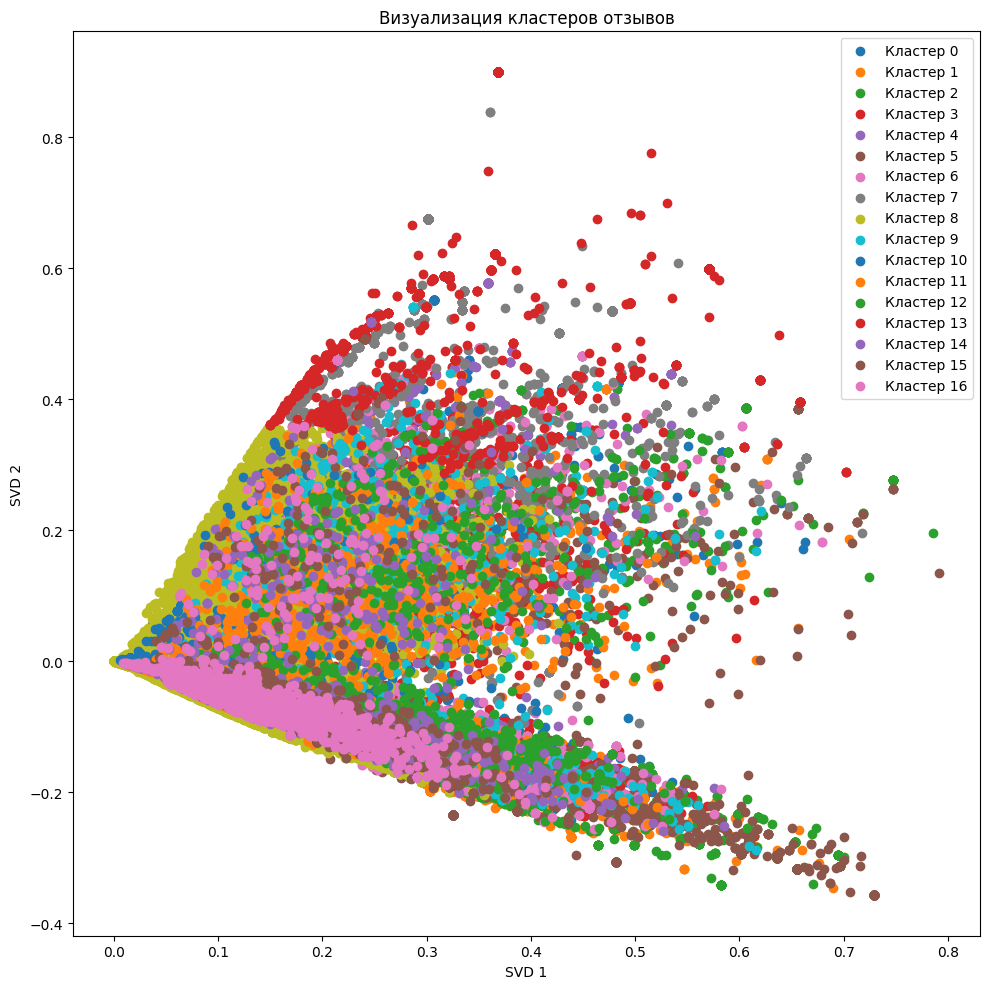

In [44]:
# Визуализация кластеров
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X)
plt.figure(figsize=(10, 10))
for cluster in range(clusters_number):
    index = russian_df['cluster'] == cluster
    plt.scatter(X_svd[index, 0], X_svd[index, 1], label=f'Кластер {cluster}')
plt.title('Визуализация кластеров отзывов')
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.legend()
plt.tight_layout()
plt.show()

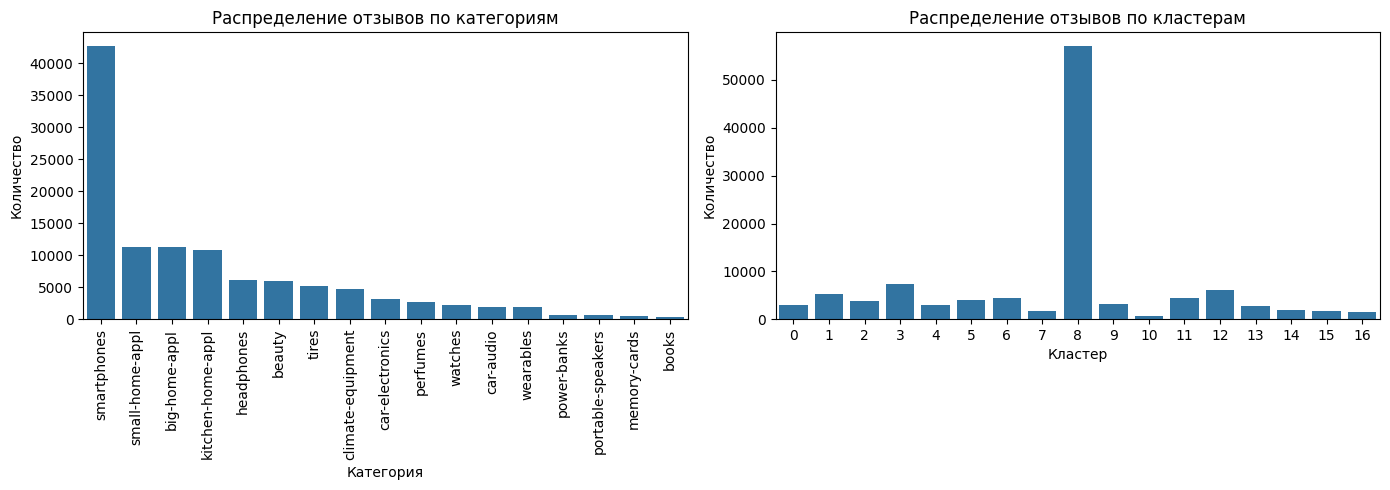

In [45]:
plt.figure(figsize=(14, 5))

# Реальное распределение по категориям
plt.subplot(1, 2, 1)
sns.countplot(x='category', data=russian_df, order=russian_df['category'].value_counts().index)
plt.title('Распределение отзывов по категориям')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=90)

# Распределение по кластерам
plt.subplot(1, 2, 2)
sns.countplot(x='cluster', data=russian_df)
plt.title('Распределение отзывов по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество')

plt.tight_layout()
plt.show()

In [46]:
# Разделение данных на 3 выборки
X = russian_df['review']
y = russian_df['category']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("train_dataset_size", {X_train.shape[0]})
print("test_dataset_size", {X_test.shape[0]})
print("val_dataset_size", {X_val.shape[0]})

train_dataset_size {78434}
test_dataset_size {16807}
val_dataset_size {16808}
